In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import threading

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipyparallel import Client 
from tqdm import tqdm

from lib.oracles import LinearLMEOracle, LinearLMEOracleRegularized
from lib.solvers import LinearLMESolver, LinearLMERegSolver
from lib.problems import LinearLMEProblem
from lib.feature_selection import FeatureSelectorV1

## LME Playground

In [4]:
study_sizes_widget = widgets.Text(value='300, 100, 50', placeholder="100, 100, 100", description='Study sizes:')
test_widget = widgets.IntSlider(min=1, max=20, value=10, step=1, description="Test size")
random_seed_widget = widgets.IntSlider(min=1, max=1000, value=212, step=1, description="Random seed")
num_features_widget = widgets.IntSlider(min=2, max=10, value=10, step=1, description="Features")
num_random_features_widget = widgets.IntSlider(min=2, max=10, value=10, step=1, description="Random effects")
how_close_widget = widgets.FloatSlider(min=0, max=1, value=1, step=0.01, description="How close?")
obs_std_widget = widgets.FloatLogSlider(min=-6, max=2, value=5e-2, step=1, description="Random noise std")
l2_beta_reg_widget = widgets.FloatLogSlider(min=-6, max=9, value=1e-5, step=1, description="L2 beta regularization")
l2_gamma_reg_widget = widgets.FloatLogSlider(min=-10, max=9, value=0.1, step=1, description="L2 gamma regularization")
features_widget = widgets.HBox([num_features_widget, num_random_features_widget])
rest_widget = widgets.HBox([obs_std_widget, random_seed_widget])

init_widget = widgets.ToggleButtons(options=['None', 'EM'], 
                                         value='EM',
                                         description='Initializer:')
method_widget = widgets.ToggleButtons(options=['GradDescent', 'NewtonRaphson', 'EM', 'VariableProjectionGD'], 
                                         value='VariableProjectionGD',
                                         description='Method:')
bootstrap_widget = widgets.ToggleButtons(options=['None', 'Parametric', 'Nonparametric', 'Analytic'], 
                                         value='None',
                                         description='Bootstrap:')
bootstrap_capacity_widget = widgets.IntSlider(min=10, max=1000, value=100, step=10, description="Bootstrap samples")
launch_log = []

def visualize_sample_problem(study_sizes="100, 100, 100",
                 test_size=5,
                 num_features=6, 
                 num_random_effects=6,
                 how_close=1,
                 lb=0.1,
                 lg=1,
                 obs_std=0.1, 
                 bootstrap='Nonparametric',
                 bootstrap_capacity=100,
                 initializer='EM',
                 method='NewtonRaphson',
                 random_seed=42):
    
    
    if study_sizes == "":
        study_sizes = [study1, study2, study3]
    else:
        study_sizes = [int(s) for s in study_sizes.split(", ")]
    test_study_sizes = [test_size]*len(study_sizes)
    
    beta = np.ones(num_features)
    gamma = np.ones(num_random_effects)
    
    beta[0] = 0
    gamma[0] = 0
    gamma[-1] = 0
        
    tol = 1e-4
    max_iter = 1000

        
    train, beta, gamma, random_effects, errs = LinearLMEProblem.generate(study_sizes=study_sizes,
                                                                         num_features=num_features,
                                                                         beta=beta,
                                                                         gamma=gamma,
                                                                         num_random_effects=num_random_effects,
                                                                         how_close_z_to_x=how_close,
                                                                         obs_std=obs_std,
                                                                         seed=random_seed)
    
    empirical_gamma = np.sum(random_effects ** 2, axis=0) / len(study_sizes)
    
    test = LinearLMEProblem.generate(study_sizes=test_study_sizes, beta=beta, gamma=gamma,
                                     how_close_z_to_x=how_close,
                                     true_random_effects=random_effects,
                                     seed=random_seed + 1, 
                                     obs_std=obs_std,
                                     return_true_parameters=False)
    true_parameters = {
        "beta": beta,
        "gamma": gamma,
        "random_effects": random_effects,
        "errs": errs,
        "train": train,
        "test": test,
        "seed": random_seed
    }
    
    color_map = ["red", "green", "blue", "yellow", "black", "cyan", "purple", "orange"]
    
    
    
    if method == "VariableProjectionGD":
        train_oracle = LinearLMEOracleRegularized(train, lb=lb, lg=lg)
        test_oracle = LinearLMEOracleRegularized(test, lb=lb, lg=lg)
        #gamma_reg_exact_full, g_opt = train_oracle.good_lambda_gamma(mode="exact_full_hess")
        #gamma_reg_exact_full = lg
        #train_oracle.lg = gamma_reg_exact_full
        #test_oracle.lg = gamma_reg_exact_full
        model = LinearLMERegSolver(tol=tol, max_iter=max_iter)
        logger = model.fit(train_oracle, test_oracle, method=method, initializer=initializer)
        #print(logger["grad_gamma_norm"])
    else:    
        train_oracle = LinearLMEOracle(train)
        test_oracle = LinearLMEOracle(test)
        model = LinearLMESolver(tol=tol, max_iter=max_iter)
        logger = model.fit(train_oracle, test_oracle, method=method, initializer=initializer)
    
    # Eigenvalues and eigenvectors at the solution
    #print(train_oracle.gradient_gamma(beta, empirical_gamma))
    #print(np.linalg.eigvals(train_oracle.hessian_gamma(beta, empirical_gamma)))
    
    if not logger["converged"]:
        print("Did not converge") 
        
    
    figsize=(16, 16)
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(4, 4, wspace=0.3, hspace=0.3)
    prediction_plot = fig.add_subplot(grid[:2, :2])


    model_parameters_plot = fig.add_subplot(grid[0, 2])
    pred_beta = model.beta
    model_parameters_plot.scatter(true_parameters['beta'], pred_beta)
    model_parameters_plot.set_xlabel("True parameters")
    model_parameters_plot.set_ylabel("Inferred parameters")
    model_parameters_low_lim = -0.5#min(min(pred_beta), min(true_parameters['beta'])) - 0.1
    model_parameters_high_lim = 1.5#max(max(pred_beta), max(true_parameters['beta'])) + 0.1
    model_parameters_plot.set_xlim(model_parameters_low_lim, model_parameters_high_lim)
    model_parameters_plot.set_ylim(model_parameters_low_lim, model_parameters_high_lim)
    model_parameters_plot.plot(model_parameters_plot.get_xlim(), model_parameters_plot.get_ylim(), ls='--', c=".3")
    
    
    random_effects_plot = fig.add_subplot(grid[1, 2])
    random_effects_low_lim = 0
    random_effects_high_lim = 0
    for i, (u_pred, u_true) in enumerate(zip(model.us, true_parameters['random_effects'])):
        random_effects_plot.scatter(u_true, u_pred, label="Study %d" % (i + 1), c=color_map[i])
        random_effects_low_lim = min(min(u_true), min(u_pred), random_effects_low_lim)
        random_effects_high_lim = max(max(u_true), max(u_pred), random_effects_high_lim)
    random_effects_plot.legend()
    random_effects_low_lim -= 0.1
    random_effects_high_lim += 0.1
    random_effects_plot.set_xlim(random_effects_low_lim, random_effects_high_lim)
    random_effects_plot.set_ylim(random_effects_low_lim, random_effects_high_lim)
    random_effects_plot.plot(random_effects_plot.get_xlim(), random_effects_plot.get_ylim(), ls='--', c=".3")
    random_effects_plot.set_xlabel("True random effects")
    random_effects_plot.set_ylabel("Inferred random effects")

    gamma_to_show = model.gamma
    gamma_plot = fig.add_subplot(grid[0, 3])
    gamma_plot.scatter(empirical_gamma, gamma_to_show, label="Inferred")
    gamma_low_lim = min(min(empirical_gamma), min(gamma_to_show)) - 0.2
    gamma_high_lim = max(max(empirical_gamma), max(gamma_to_show)) + 0.2
    gamma_plot.set_xlim(gamma_low_lim, gamma_high_lim)
    gamma_plot.set_ylim(gamma_low_lim, gamma_high_lim)
    gamma_plot.plot(gamma_plot.get_xlim(), gamma_plot.get_ylim(), ls='--', c=".3")
    gamma_plot.set_xlabel("Empirical gamma")
    gamma_plot.set_ylabel("Inferred gamma")

    abs_min = np.inf
    if num_random_effects == 2:
        trajectory_plot = fig.add_subplot(grid[2:4, 0:2])
    
        xlims = [0, 2] #ax.get_xlim()
        ylims = [0, 2] #ax.get_ylim()

        plot_resolution = 100
        x = np.linspace(0, xlims[1], plot_resolution)
        y = np.linspace(0, ylims[1], plot_resolution)
        z = np.zeros((plot_resolution, plot_resolution))
        zh = np.zeros((plot_resolution, plot_resolution))
        def psd(hessian):
            eigvals = np.linalg.eigvals(hessian)
            if np.linalg.norm(np.imag(eigvals)) > 1e-15:
                return -1
            min_eigval = min(np.real(eigvals))
            if min_eigval < 0:
                return -1
            else:
                return min_eigval
        for i, g2 in enumerate(y):
            for j, g1 in enumerate(x):
                gamma0 = np.array([g1, g2])
                beta0 = train_oracle.optimal_beta(gamma0)
                z[i, j] = train_oracle.loss(beta0, gamma0)
                hessian = train_oracle.hessian_gamma(beta0, gamma0)
                zh[i, j] = psd(hessian)

        abs_min = min(min(logger["loss"]), np.min(z)) - 1e-8

        csh = trajectory_plot.contourf(x, y, zh, levels=[0, 1e13], colors="lightgreen")

        levels = np.min(z) + np.array([1e-2, 1e-1, 1e0, 1e1, 1e2])
        levels_labels = ["1e-2", "1e-1", "1e0", "1e1", "1e2"]
        levels_dict = {levels[i]: levels_labels[i] for i in range(len(levels_labels))}

        cs = trajectory_plot.contour(x, y, z, levels=levels)
        plt.clabel(cs, fontsize=8, fmt=levels_dict)


        gamma_trace = np.array(logger["gamma"]).T
        trajectory_plot.plot(gamma_trace[0], gamma_trace[1], '-ob', label = method)

        trajectory_plot.set_xlim(xlims)
        trajectory_plot.set_ylim(ylims)
        trajectory_plot.set_xlabel(r"$\gamma_1$, variation of the first random effect")
        trajectory_plot.set_ylabel(r"$\gamma_2$, variation of the second random effect")
        
        extra_plot = fig.add_subplot(grid[2:4, 2:4])
        
        def psd_criterion(gamma_t):
            beta_t = train_oracle.optimal_beta(gamma_t)
            criterion_satisfied = []
            gamma_mat = np.diag(gamma_t)
            for x, y, z, l in train:
                omega = z.dot(gamma_mat).dot(z.T) + l
                xi = y - x.dot(beta_t)
                criterion_satisfied.append(xi.T.dot(np.linalg.inv(omega)).dot(xi) <= 1/2)
            return sum(criterion_satisfied)
        
        zc = np.zeros((plot_resolution, plot_resolution))
        for i, g2 in enumerate(y):
            for j, g1 in enumerate(x):
                gamma_t = np.array([g1, g2])
                zc[i, j] = psd_criterion(gamma_t)
                                
        cc = extra_plot.contourf(x, y, zc)
        cs = extra_plot.contour(x, y, z, levels=levels)
        plt.clabel(cs, fontsize=8, fmt=levels_dict)
        extra_plot.set_xlim(xlims)
        extra_plot.set_ylim(ylims)
        extra_plot.set_xlabel(r"$\gamma_1$, variation of the first random effect")
        extra_plot.set_ylabel(r"$\gamma_2$, variation of the second random effect")

    #loss_plot = fig.add_subplot(grid[1, 3])
    #min_loss = min(np.min(logger["loss"]), abs_min)
    #loss_plot.semilogy(range(len(logger["loss"])), logger["loss"] - min_loss + 1e-8, '-ob', label=method)
    #loss_plot.set_ylim((1e-8, 1e3))
    
    grad_plot = fig.add_subplot(grid[1, 3])
    #grad_norm = [np.linalg.norm(gamma) for gamma in logger["grad_gamma"]]
    grad_plot.semilogy(range(len(logger["grad_gamma_norm"])), logger["grad_gamma_norm"], '-ob', label=method)
    grad_plot.set_xlabel("Number of iteration")
    grad_plot.set_ylabel("Gradient norm")
    ylims = grad_plot.get_ylim()
    grad_plot.set_ylim(min(tol/10, ylims[0]), ylims[1])
    
    plt.show()
    
    print("True beta: %s"%(" ".join("%.2f"%s for s in beta.tolist())))
    print("Model beta: %s"%(" ".join("%.2f"%s for s in model.beta.tolist())))
    if method == "VariableProjectionNR":
        print("Model tbeta: %s"%(" ".join("%.2f"%s for s in model.tbeta.tolist())))
    print(" ")
    print("Empirical gamma: %s"%(" ".join("%.2f"%s for s in empirical_gamma.tolist())))
    print("Model gamma: %s"%(" ".join("%.2f"%s for s in model.gamma.tolist())))
    if method == "VariableProjectionNR":
        print("Model tgamma: %s"%(" ".join("%.2f"%s for s in model.tgamma.tolist())))
    
    launch_log.append(true_parameters)

In [5]:
interact_manual(visualize_sample_problem, 
                study_sizes = study_sizes_widget,
                test_size = test_widget,
                num_features = num_features_widget,
                num_random_effects = num_random_features_widget,
                how_close = how_close_widget,
                lb=l2_beta_reg_widget,
                lg=l2_gamma_reg_widget,
                obs_std = obs_std_widget,
                bootstrap = bootstrap_widget,
                bootstrap_capacity = bootstrap_capacity_widget,
                initializer = init_widget, 
                method = method_widget,
                random_seed = random_seed_widget)

interactive(children=(Text(value='300, 100, 50', description='Study sizes:', placeholder='100, 100, 100'), Int…

<function __main__.visualize_sample_problem(study_sizes='100, 100, 100', test_size=5, num_features=6, num_random_effects=6, how_close=1, lb=0.1, lg=1, obs_std=0.1, bootstrap='Nonparametric', bootstrap_capacity=100, initializer='EM', method='NewtonRaphson', random_seed=42)>

## Feature Selection Playground

In [47]:
study_sizes_widget = widgets.Text(value='300, 100, 50', placeholder="100, 100, 100", description='Study sizes:')
test_widget = widgets.IntSlider(min=1, max=20, value=10, step=1, description="Test size")
random_seed_widget = widgets.IntSlider(min=1, max=1000, value=413, step=1, description="Random seed")
num_features_widget = widgets.IntSlider(min=2, max=10, value=6, step=1, description="Features")
num_random_features_widget = widgets.IntSlider(min=2, max=10, value=6, step=1, description="Random effects")
how_close_widget = widgets.FloatSlider(min=0, max=1, value=1, step=0.01, description="How close?")
obs_std_widget = widgets.FloatLogSlider(min=-6, max=2, value=5e-2, step=1, description="Random noise std")
l2_beta_reg_widget = widgets.FloatLogSlider(min=-3, max=5, value=1, step=1, description="L2 beta regularization")
l2_gamma_reg_widget = widgets.FloatLogSlider(min=-3, max=5, value=1, step=1, description="L2 gamma regularization")
features_widget = widgets.HBox([num_features_widget, num_random_features_widget])
rest_widget = widgets.HBox([obs_std_widget, random_seed_widget])

init_widget = widgets.ToggleButtons(options=['None', 'EM'], 
                                         value='None',
                                         description='Initializer:')
method_widget = widgets.ToggleButtons(options=['GradDescent', 'NewtonRaphson', 'EM', 'VariableProjectionGD'], 
                                         value='VariableProjectionGD',
                                         description='Method:')
bootstrap_widget = widgets.ToggleButtons(options=['None', 'Parametric', 'Nonparametric', 'Analytic'], 
                                         value='None',
                                         description='Bootstrap:')
bootstrap_capacity_widget = widgets.IntSlider(min=10, max=1000, value=100, step=10, description="Bootstrap samples")
launch_log = []

def visualize_sample_problem(study_sizes="100, 100, 100",
                 test_size=5,   # that's how much objects is going to be in test _for each study_
                 num_features=6, 
                 num_random_effects=6,
                 how_close=1, # how close Z to X: Z := how_close*Z + (1-how_close)*X (need it for instability testing)                                                                    
                 lb=0.1,     # \lambda for regularizer ||beta - wobbly_beta||
                 lg=1,       # \lambda for regularizer ||gamma - wobbly_gamma||
                 obs_std=0.1,  # diagonal elements of \Lambda (noise variance)
                 bootstrap='Nonparametric', 
                 bootstrap_capacity=100,
                 initializer='None',
                 method='NewtonRaphson',
                 random_seed=42):
    
    figsize=(16, 16)
    tol = 1e-4
    max_iter = 1000
    
    if study_sizes == "":
        study_sizes = [study1, study2, study3]
    else:
        study_sizes = [int(s) for s in study_sizes.split(", ")]
    test_study_sizes = [test_size]*len(study_sizes)
    
    # beta is [0, 1, 1, 1 ...]
    # gamma is [0, 1, 1, ..., 1, 0]
    beta = np.ones(num_features)
    gamma = np.ones(num_random_effects)
    
    beta[-1] = 0
    gamma[0] = 0
    gamma[-1] = 0
     
    train, beta, gamma, random_effects, errs = LinearLMEProblem.generate(study_sizes=study_sizes,
                                                                         num_features=num_features,
                                                                         beta=beta,
                                                                         gamma=gamma,
                                                                         num_random_effects=num_random_effects,
                                                                         how_close_z_to_x=how_close,
                                                                         obs_std=obs_std,
                                                                         seed=random_seed)
    
    # this is the best gamma one can have a hope to find
    empirical_gamma = np.sum(random_effects ** 2, axis=0) / len(study_sizes)
    
    test = LinearLMEProblem.generate(study_sizes=test_study_sizes, beta=beta, gamma=gamma,
                                     how_close_z_to_x=how_close,
                                     true_random_effects=random_effects,
                                     seed=random_seed + 1, 
                                     obs_std=obs_std,
                                     return_true_parameters=False)
    true_parameters = {
        "beta": beta,
        "gamma": gamma,
        "random_effects": random_effects,
        "errs": errs,
        "train": train,
        "test": test,
        "seed": random_seed
    }
    
    color_map = ["red", "green", "blue", "yellow", "black", "cyan", "purple", "orange"]
    
    
    if method == "VariableProjectionGD":
        # these are oracle and method which are capable of performing feature selection 
        train_oracle = LinearLMEOracleRegularized(train, lb=lb, lg=lg)
        test_oracle = LinearLMEOracleRegularized(test, lb=lb, lg=lg)
        model = LinearLMERegSolver(tol=tol, max_iter=max_iter)
        # this says what regularizer we need to put in order to make the hessian PSD everywhere
        # UPD: we don't use it, because we don't use NR anymore (we use GD instead)
        # gamma_reg_exact_full, g_opt = train_oracle.good_lambda_gamma(mode="exact_full_hess")
        # print(r"Suggested $\lambda_\gamma$ adjustment: ", gamma_reg_exact_full)
        # print(r"Used $\lambda_\gamma$: ", lg)
    else:    
        # these methods are left here for experimenting, they don't work for feature selection
        # because they behave badly near the boundaries
        train_oracle = LinearLMEOracle(train)
        test_oracle = LinearLMEOracle(test)
        model = LinearLMESolver(tol=tol, max_iter=max_iter)
        
    # We start the feature selection process from a "one EM iteration" initial point
    model.max_iter = 0
    logger = model.fit(train_oracle,
                        test_oracle,
                        beta0=np.ones(num_features),
                        gamma0=np.ones(num_random_effects),
                        initializer="EM",
                        )
    model.max_iter = max_iter

    # These are initial parameters for the very first iteration
    parameters = {
        (num_features + 1, num_random_effects): (model.beta, model.gamma, None)
    }
    
    # k is how much non-zero elements of beta we want to get
    for k in range(num_features, 0, -1):
        train_oracle.k = k
        test_oracle.k = k
        prev_beta, *rest = parameters[(k + 1, k)]
        tbeta = train_oracle.take_only_k_max(prev_beta, k)
        
        for j in range(k, 0, -1):
            train_oracle.j = j
            test_oracle.j = j
            if j == k:
                prev_beta, prev_gamma, *rest = parameters[(k + 1, k)]
            else:
                prev_beta, prev_gamma, *rest = parameters[(k, j + 1)]
                
            tgamma = prev_gamma
            tgamma[tbeta==0] = 0
            tgamma = train_oracle.take_only_k_max(tgamma, j)
        
            #print(k, j, ": \n Beta: ", prev_beta, '\n Gamma: ', prev_gamma, '\n tbeta: ', tbeta, '\n tgamma:', tgamma, '\n')
            logger = model.fit(train_oracle,
                               test_oracle,
                               beta0=prev_beta,
                               gamma0=prev_gamma,
                               tbeta=tbeta,
                               tgamma=tgamma,
                                method=method,
                               initializer=None,
                               use_line_search=True
                               )
            #print(k, j, " after: \n Beta: ", model.beta, '\n Gamma: ', model.gamma, '\n tbeta: ', model.tbeta, '\n tgamma:', model.tgamma, '\n')

            train_loss = train_oracle.loss_reg(model.beta, model.gamma, tbeta, tgamma)
            test_loss = test_oracle.loss_reg(model.beta, model.gamma, tbeta, tgamma)
            if not logger["converged"]:
                parameters[(k, j)] = (prev_beta, prev_gamma, tbeta, tgamma, logger, train_loss, test_loss)
            else:
                parameters[(k, j)] = (model.beta, model.gamma, model.tbeta, model.tgamma, logger, train_loss, test_loss)
            
        
    train_error = np.zeros((num_features, num_features))
    test_error = np.zeros((num_features, num_features))
    converged = np.zeros((num_features, num_features))
    coefficients = np.zeros((num_features*num_features, 2*num_features))
    dense_coefficients = np.zeros((num_features*num_features, 2*num_features))
    for k in range(num_features, 0, -1):
        for j in range(k, 0, -1):
            beta, gamma, tbeta, tgamma, logger, train_loss, test_loss = parameters[(k, j)]
            train_error[k-1, j-1] = train_loss
            test_error[k-1, j-1] = test_loss
            converged[k-1, j-1] = logger["converged"]
            
            dense_coefficients[(k-1)*num_features:k*num_features, 2*(j-1)] = beta
            dense_coefficients[(k-1)*num_features:k*num_features, 2*(j-1)+1] = gamma

            coefficients[(k-1)*num_features:k*num_features, 2*(j-1)] = tbeta
            coefficients[(k-1)*num_features:k*num_features, 2*(j-1)+1] = tgamma
    
    coefficients[:num_features, 2*(num_features-1)] = true_parameters["beta"]
    coefficients[:num_features, 2*(num_features-1)+1] = empirical_gamma
    
    dense_coefficients[:num_features, 2*(num_features-1)] = true_parameters["beta"]
    dense_coefficients[:num_features, 2*(num_features-1)+1] = empirical_gamma
    
    print("Convergence:")
    print(converged.T, '\n')
    
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(4, 4, wspace=0.3, hspace=0.3)
    
    dense_coefficients_plot = fig.add_subplot(grid[:2, :])
    dense_coefficients_plot.imshow(dense_coefficients.T)
    for k in range(num_features, 0, -1):
        for j in range(k, 0, -1):
            for l in range(num_features):
                coef_beta = dense_coefficients[(k-1)*num_features+l, 2*(j-1)]
                coef_beta_str = "0" if coef_beta == 0 else "%.2f"%coef_beta
                coef_gamma = dense_coefficients[(k-1)*num_features+l, 2*(j-1)+1]
                coef_gamma_str = "0" if coef_gamma == 0 else "%.2f"%coef_gamma
                dense_coefficients_plot.text((k-1)*num_features+l, 2*(j-1), coef_beta_str, ha="center", va="center", color="w")
                dense_coefficients_plot.text((k-1)*num_features+l, 2*(j-1)+1, coef_gamma_str, ha="center", va="center", color="w")
    
    for l in range(num_features):
        coef_beta = dense_coefficients[l, 2*(num_features-1)]
        coef_beta_str = "0" if coef_beta == 0 else "%.2f"%coef_beta
        coef_gamma = dense_coefficients[l, 2*(num_features-1)+1]
        coef_gamma_str = "0" if coef_gamma == 0 else "%.2f"%coef_gamma
        dense_coefficients_plot.text(l, 2*(num_features-1), coef_beta_str, ha="center", va="center", color="w")
        dense_coefficients_plot.text(l, 2*(num_features-1)+1, coef_gamma_str, ha="center", va="center", color="w")
    
        
    dense_coefficients_plot.set_xticks(np.arange(-0.5, num_features*num_features, num_features))
    dense_coefficients_plot.set_xticklabels(np.arange(num_features)+1)
    dense_coefficients_plot.set_yticks(np.arange(-0.5, 2*num_features, 2))
    dense_coefficients_plot.set_yticklabels(np.arange(1, num_features+1).tolist() + [""])
    dense_coefficients_plot.grid(which="major", color='r', linestyle='-', linewidth=2)
    dense_coefficients_plot.set_title("Betas and Gammas (probably dense solutions)")
    
    ### Sparse coefficients
    coefficients_plot = fig.add_subplot(grid[2:4, :])
    coefficients_plot.imshow(coefficients.T)
    for k in range(num_features, 0, -1):
        for j in range(k, 0, -1):
            for l in range(num_features):
                coef_beta = coefficients[(k-1)*num_features+l, 2*(j-1)]
                coef_beta_str = "0" if coef_beta == 0 else "%.2f"%coef_beta
                coef_gamma = coefficients[(k-1)*num_features+l, 2*(j-1)+1]
                coef_gamma_str = "0" if coef_gamma == 0 else "%.2f"%coef_gamma
                coefficients_plot.text((k-1)*num_features+l, 2*(j-1), coef_beta_str, ha="center", va="center", color="w")
                coefficients_plot.text((k-1)*num_features+l, 2*(j-1)+1, coef_gamma_str, ha="center", va="center", color="w")
    
    for l in range(num_features):
        coef_beta = coefficients[l, 2*(num_features-1)]
        coef_beta_str = "0" if coef_beta == 0 else "%.2f"%coef_beta
        coef_gamma = coefficients[l, 2*(num_features-1)+1]
        coef_gamma_str = "0" if coef_gamma == 0 else "%.2f"%coef_gamma
        coefficients_plot.text(l, 2*(num_features-1), coef_beta_str, ha="center", va="center", color="w")
        coefficients_plot.text(l, 2*(num_features-1)+1, coef_gamma_str, ha="center", va="center", color="w")
    
        
    coefficients_plot.set_xticks(np.arange(-0.5, num_features*num_features, num_features))
    coefficients_plot.set_xticklabels(np.arange(num_features)+1)
    coefficients_plot.set_yticks(np.arange(-0.5, 2*num_features, 2))
    coefficients_plot.set_yticklabels(np.arange(1, num_features+1).tolist() + [""])
    coefficients_plot.grid(which="major", color='r', linestyle='-', linewidth=2)
    coefficients_plot.set_title("Wobbly Betas and Gammas (sparse solutions)")


    #coefficients_plot.set_ylim((0, 2*num_features))
    
    #print(train_error)
    #print(test_error)

In [48]:
interact_manual(visualize_sample_problem, 
                study_sizes = study_sizes_widget,
                test_size = test_widget,
                num_features = num_features_widget,
                num_random_effects = num_random_features_widget,
                how_close = how_close_widget,
                lb=l2_beta_reg_widget,
                lg=l2_gamma_reg_widget,
                obs_std = obs_std_widget,
                bootstrap = bootstrap_widget,
                bootstrap_capacity = bootstrap_capacity_widget,
                initializer = init_widget, 
                method = method_widget,
                random_seed = random_seed_widget)

interactive(children=(Text(value='300, 100, 50', description='Study sizes:', placeholder='100, 100, 100'), Int…

<function __main__.visualize_sample_problem(study_sizes='100, 100, 100', test_size=5, num_features=6, num_random_effects=6, how_close=1, lb=0.1, lg=1, obs_std=0.1, bootstrap='Nonparametric', bootstrap_capacity=100, initializer='None', method='NewtonRaphson', random_seed=42)>

# Refactored feature selection

In [126]:
study_sizes_widget = widgets.Text(value='300, 100, 50', placeholder="100, 100, 100", description='Study sizes:')
test_widget = widgets.IntSlider(min=1, max=20, value=10, step=1, description="Test size")
random_seed_widget = widgets.IntSlider(min=1, max=1000, value=413, step=1, description="Random seed")
num_features_widget = widgets.IntSlider(min=2, max=10, value=6, step=1, description="Features")
num_random_features_widget = widgets.IntSlider(min=2, max=10, value=6, step=1, description="Random effects")
how_close_widget = widgets.FloatSlider(min=0, max=1, value=1, step=0.01, description="How close?")
obs_std_widget = widgets.FloatLogSlider(min=-6, max=2, value=5e-2, step=1, description="Random noise std")
l2_beta_reg_widget = widgets.FloatLogSlider(min=-3, max=5, value=1, step=1, description="L2 beta regularization")
l2_gamma_reg_widget = widgets.FloatLogSlider(min=-3, max=5, value=10, step=1, description="L2 gamma regularization")
features_widget = widgets.HBox([num_features_widget, num_random_features_widget])
rest_widget = widgets.HBox([obs_std_widget, random_seed_widget])

init_widget = widgets.ToggleButtons(options=['None', 'EM'], 
                                         value='None',
                                         description='Initializer:')
method_widget = widgets.ToggleButtons(options=['GradDescent', 'NewtonRaphson', 'EM', 'VariableProjectionGD'], 
                                         value='VariableProjectionGD',
                                         description='Method:')
bootstrap_widget = widgets.ToggleButtons(options=['None', 'Parametric', 'Nonparametric', 'Analytic'], 
                                         value='None',
                                         description='Bootstrap:')
bootstrap_capacity_widget = widgets.IntSlider(min=10, max=1000, value=100, step=10, description="Bootstrap samples")
launch_log = []

def visualize_sample_problem(study_sizes="100, 100, 100",
                 test_size=5,   # that's how much objects is going to be in test _for each study_
                 num_features=6, 
                 num_random_effects=6,
                 how_close=1, # how close Z to X: Z := how_close*Z + (1-how_close)*X (need it for instability testing)                                                                    
                 lb=0.1,     # \lambda for regularizer ||beta - wobbly_beta||
                 lg=1,       # \lambda for regularizer ||gamma - wobbly_gamma||
                 obs_std=0.1,  # diagonal elements of \Lambda (noise variance)
                 bootstrap='Nonparametric', 
                 bootstrap_capacity=100,
                 initializer='None',
                 method='NewtonRaphson',
                 random_seed=42):
    
    figsize=(16, 16)
    tol = 1e-4
    max_iter = 1000
    max_iter_t = 100
    
    if study_sizes == "":
        study_sizes = [study1, study2, study3]
    else:
        study_sizes = [int(s) for s in study_sizes.split(", ")]
    test_study_sizes = [test_size]*len(study_sizes)
    
    # beta is [0, 1, 1, 1 ...]
    # gamma is [0, 1, 1, ..., 1, 0]
    beta = np.ones(num_features)
    gamma = np.ones(num_random_effects)
    
    beta[-1] = 0
    gamma[0] = 0
    gamma[-1] = 0
     
    train, beta, gamma, random_effects, errs = LinearLMEProblem.generate(study_sizes=study_sizes,
                                                                         num_features=num_features,
                                                                         beta=beta,
                                                                         gamma=gamma,
                                                                         num_random_effects=num_random_effects,
                                                                         how_close_z_to_x=how_close,
                                                                         obs_std=obs_std,
                                                                         seed=random_seed)
    
    # this is the best gamma one can have a hope to find
    empirical_gamma = np.sum(random_effects ** 2, axis=0) / len(study_sizes)
    
    test = LinearLMEProblem.generate(study_sizes=test_study_sizes, beta=beta, gamma=gamma,
                                     how_close_z_to_x=how_close,
                                     true_random_effects=random_effects,
                                     seed=random_seed + 1, 
                                     obs_std=obs_std,
                                     return_true_parameters=False)
    true_parameters = {
        "beta": beta,
        "gamma": gamma,
        "random_effects": random_effects,
        "errs": errs,
        "train": train,
        "test": test,
        "seed": random_seed
    }
    
    color_map = ["red", "green", "blue", "yellow", "black", "cyan", "purple", "orange"]
    
    
    if method == "VariableProjectionGD":
        # these are oracle and method which are capable of performing feature selection 
        train_oracle = LinearLMEOracleRegularized(train, lb=lb, lg=lg)
        test_oracle = LinearLMEOracleRegularized(test, lb=lb, lg=lg)
        model = LinearLMERegSolver(tol=tol, max_iter=max_iter)
    else:    
        # these methods are left here for experimenting, they don't work for feature selection
        # because they behave badly near the boundaries
        train_oracle = LinearLMEOracle(train)
        test_oracle = LinearLMEOracle(test)
        model = LinearLMESolver(tol=tol, max_iter=max_iter)
        
    # We start the feature selection process from a "one EM iteration" initial point
    model.max_iter = 0
    logger = model.fit(train_oracle,
                        test_oracle,
                        beta0=np.ones(num_features),
                        gamma0=np.ones(num_random_effects),
                        initializer="EM",
                        )
    beta0 = model.beta
    gamma0 = model.gamma
    
    # Or we start it at some bad point
    # beta0 = np.ones(num_features)/2
    # gamma0 = np.ones(num_random_effects)/2
    
    model.max_iter = max_iter

    feature_selector = FeatureSelectorV1(max_iter=max_iter_t, tol=tol)
    feature_selector.fit(train_oracle,
                        test_oracle,
                        model,
                        beta0=beta0,
                        gamma0=gamma0,
                        logger_keys=('loss', 'test_loss', 'proj_grad_gamma_norm', "converged", 
                                    'loss_wo_reg', 'loss_wo_reg_tgamma', 'test_loss_wo_reg', 'test_loss_wo_reg_tgamma'),
                        method="VariableProjectionGD", 
                        use_line_search=True,
                        selection_mode=None)
    
    train_error = feature_selector.get_aggregated_parameter("loss")
    test_error = feature_selector.get_aggregated_parameter("test_loss")
    dense_loss_train = feature_selector.get_aggregated_parameter("loss_wo_reg")
    sparse_loss_train = feature_selector.get_aggregated_parameter("loss_wo_reg_tgamma")
    dense_loss_test = feature_selector.get_aggregated_parameter("test_loss_wo_reg")
    sparse_loss_test = feature_selector.get_aggregated_parameter("test_loss_wo_reg_tgamma")
    
    converged = feature_selector.get_aggregated_parameter("converged")
    inner_iters = feature_selector.get_aggregated_parameter("inner_iters_total")
    all_betas = feature_selector.get_aggregated_parameter("beta")
    all_gammas = feature_selector.get_aggregated_parameter("gamma")
    all_tbetas = feature_selector.get_aggregated_parameter("tbeta")
    all_tgammas = feature_selector.get_aggregated_parameter("tgamma")
    dense_coefficients_flattened = np.zeros((num_features*num_features, 2*num_features))
    sparse_coefficients_flattened = np.zeros((num_features*num_features, 2*num_features))
    
    # flattening coefficiens matrix (from 4d to 2d) 
    # TODO: there is probably an easier way through .reshape
    for k in range(num_features, 0, -1):
        for j in range(k, 0, -1):
            dense_coefficients_flattened[(k-1)*num_features:k*num_features, 2*(j-1)] = all_betas[k-1, j-1]
            dense_coefficients_flattened[(k-1)*num_features:k*num_features, 2*(j-1)+1] = all_gammas[k-1, j-1]
            sparse_coefficients_flattened[(k-1)*num_features:k*num_features, 2*(j-1)] = all_tbetas[k-1, j-1]
            sparse_coefficients_flattened[(k-1)*num_features:k*num_features, 2*(j-1)+1] = all_tgammas[k-1, j-1]
    
    # we put the true coefficients to the bottom-left corner of this matrix for both beta/gamma and tbeta/tgamma
    dense_coefficients_flattened[:num_features, 2*(num_features-1)] = true_parameters["beta"]
    dense_coefficients_flattened[:num_features, 2*(num_features-1)+1] = empirical_gamma
    sparse_coefficients_flattened[:num_features, 2*(num_features-1)] = true_parameters["beta"]
    sparse_coefficients_flattened[:num_features, 2*(num_features-1)+1] = empirical_gamma
    
    
    # printing the convergence matrix
    np.set_printoptions(precision=2)
    print("Convergence:")
    print(converged.T, '\n')
    print("Internal convergence:")
    print(inner_iters.T, '\n')
    print("Loss:")
    print(train_error.T, '\n')
    print("Pure Dense Loss:")
    print(dense_loss_train.T, '\n')
    print("Pure Sparse Loss:")
    print(sparse_loss_train.T, '\n')
    
    # creating the main canvas and a grid for all the subplotas
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(4, 4, wspace=0.3, hspace=0.3)
        
    def plot_all_model_coefficients(coefs, ax):
        ax.imshow(coefs.T)
        for k in range(num_features, 0, -1):
            for j in range(k, 0, -1):
                for l in range(num_features):
                    coef_beta = coefs[(k-1)*num_features+l, 2*(j-1)]
                    coef_beta_str = "0" if coef_beta == 0 else "%.2f"%coef_beta
                    coef_gamma = coefs[(k-1)*num_features+l, 2*(j-1)+1]
                    coef_gamma_str = "0" if coef_gamma == 0 else "%.2f"%coef_gamma
                    ax.text((k-1)*num_features+l, 2*(j-1), coef_beta_str, ha="center", va="center", color="w")
                    ax.text((k-1)*num_features+l, 2*(j-1)+1, coef_gamma_str, ha="center", va="center", color="w")

        for l in range(num_features):
            coef_beta = coefs[l, 2*(num_features-1)]
            coef_beta_str = "0" if coef_beta == 0 else "%.2f"%coef_beta
            coef_gamma = coefs[l, 2*(num_features-1)+1]
            coef_gamma_str = "0" if coef_gamma == 0 else "%.2f"%coef_gamma
            ax.text(l, 2*(num_features-1), coef_beta_str, ha="center", va="center", color="w")
            ax.text(l, 2*(num_features-1)+1, coef_gamma_str, ha="center", va="center", color="w")


        ax.set_xticks(np.arange(-0.5, num_features*num_features, num_features))
        ax.set_xticklabels(np.arange(num_features)+1)
        ax.set_yticks(np.arange(-0.5, 2*num_features, 2))
        ax.set_yticklabels(np.arange(1, num_features+1).tolist() + [""])
        ax.grid(which="major", color='r', linestyle='-', linewidth=2)
    
    # filling up the plot for beta/gamma
    dense_coefficients_plot = fig.add_subplot(grid[:2, :])
    dense_coefficients_plot.set_title("Betas and Gammas (probably dense solutions)")
    plot_all_model_coefficients(dense_coefficients_flattened, dense_coefficients_plot)
    
    # filling up the plot for tbeta/tgamma
    sparse_coefficients_plot = fig.add_subplot(grid[2:4, :])
    sparse_coefficients_plot.set_title("Wobbly Betas and Gammas (sparse solutions)")
    plot_all_model_coefficients(sparse_coefficients_flattened, sparse_coefficients_plot)



In [127]:
interact_manual(visualize_sample_problem, 
                study_sizes = study_sizes_widget,
                test_size = test_widget,
                num_features = num_features_widget,
                num_random_effects = num_random_features_widget,
                how_close = how_close_widget,
                lb=l2_beta_reg_widget,
                lg=l2_gamma_reg_widget,
                obs_std = obs_std_widget,
                bootstrap = bootstrap_widget,
                bootstrap_capacity = bootstrap_capacity_widget,
                initializer = init_widget, 
                method = method_widget,
                random_seed = random_seed_widget)

interactive(children=(Text(value='300, 100, 50', description='Study sizes:', placeholder='100, 100, 100'), Int…

<function __main__.visualize_sample_problem(study_sizes='100, 100, 100', test_size=5, num_features=6, num_random_effects=6, how_close=1, lb=0.1, lg=1, obs_std=0.1, bootstrap='Nonparametric', bootstrap_capacity=100, initializer='None', method='NewtonRaphson', random_seed=42)>

## Creating correlated data

In [120]:
rho = 0.7
A = np.random.randn(10, 1)
B = np.random.randn(10, 1)
B_ort = B - A*np.linalg.lstsq(A, B)[0][0, 0]
print(sum(A*B_ort))
C = rho*A + sqrt(1-rho**2)*B_ort
print(A.T)
print(C.T)

1.3877787807814457e-16
[[ 1.22 -0.89 -0.99 -0.89 -0.68  0.72 -0.71  1.02 -0.91 -0.13]]
[[ 0.47 -1.1  -1.32  0.38 -2.2  -0.34  1.2   1.51 -0.96  1.27]]


/Users/aksh/.anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [121]:
from scipy.stats.stats import pearsonr   

In [123]:
pearsonr(B.T[0], C.T[0])

(0.9780057911287948, 9.970171802832275e-07)

## Fast diagonal

In [16]:
np.random.seed(42)
A = np.random.rand(3, 3)
B = np.random.rand(3, 3)

In [22]:
np.diag(A.dot(B))

array([1.19086771, 0.09291206, 0.52926729])

In [24]:
sum(A*B.T, axis=1)

array([1.19086771, 0.09291206, 0.52926729])

In [9]:
from scipy.linalg.lapack import get_lapack_funcs

In [35]:
L = np.linalg.cholesky(A.T.dot(A))
L_inv = get_lapack_funcs("trtri")(L.T)[0]

In [36]:
np.linalg.inv(L.T)

array([[  1.41132895,  -0.91609052,  -3.00017273],
       [  0.        ,   0.92021979, -22.88155172],
       [  0.        ,   0.        ,  32.15762143]])

In [37]:
L_inv

array([[  1.41132895,  -0.91609052,  -3.00017273],
       [  0.        ,   0.92021979, -22.88155172],
       [  0.        ,   0.        ,  32.15762143]])

In [45]:
np.linalg.cholesky(A.T.dot(A))

array([[0.70855204, 0.        , 0.        ],
       [0.70537257, 1.0866969 , 0.        ],
       [0.56800835, 0.77323229, 0.03109683]])

## Nature of instability 

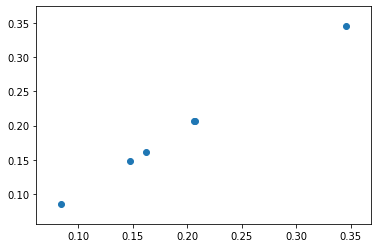

In [58]:
m = 30
n = 6
eps = 1e-7
np.random.seed(42)

def f(alpha):
    kernel = 0
    kernel2 = 0
    tail = 0
    tail2 = 0
    for _ in range(3):
        X = np.random.rand(m, n)
        Z = np.random.rand(m, n)
        y = np.random.rand(m)
        gamma = abs(np.random.randn(n))
        Z = (1-alpha)*X + alpha*Z
        Omega = Z.dot(np.diag(gamma)).dot(Z.T) + eps*np.eye(m)
        L = np.linalg.cholesky(Omega)
        L_inv = np.linalg.inv(L)
        Lx = L_inv.dot(X)
        Omega_inv = np.linalg.inv(Omega)
        kernel += X.T.dot(Omega_inv).dot(X)
        kernel2 += Lx.T.dot(Lx)
        tail += X.T.dot(Omega_inv).dot(y)
        tail2 += Lx.T.dot(L_inv).dot(y)
    beta1 = np.linalg.inv(kernel).dot(tail)
    beta2 = np.linalg.solve(kernel2, tail2)
    return beta1, beta2

beta1, beta2 = f(0)
scatter(beta1, beta2)